[*********************100%***********************]  15 of 15 completed


Best Combination(Annual): vol = 35.49%, ret = 35.96%, sharpe = 0.91
Each Weight: 
UNH      0.3171
TTWO     0.2051
AMZN     0.1672
AMD      0.0638
BAC      0.0510
NVDA     0.0376
WMT      0.0312
JNJ      0.0303
BRK-B    0.0239
AAPL     0.0220
TSLA     0.0136
FOUR     0.0122
DIS      0.0101
META     0.0076
KO       0.0074
dtype: float64


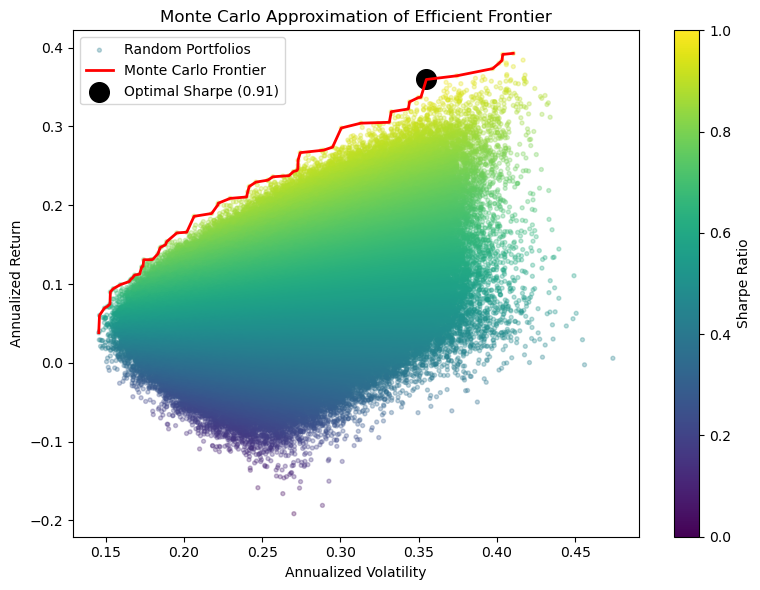

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

tickers = ['NVDA','BAC','FOUR','WMT','KO','DIS','TSLA','TTWO',
               'UNH','META','AMD','BRK-B','AAPL','AMZN','JNJ']
train_start = '2021-06-01'
train_end = '2023-05-31'
DAYS = 252
rf = 0.035

prices = yf.download(tickers, start = train_start, end = train_end, auto_adjust = True)['Close']
rets = prices.pct_change().dropna()
mu = rets.mean() * DAYS
cov = rets.cov() * DAYS
n = len(tickers)

np.random.seed(234)
n_port = 1000000
cloud = np.zeros((n_port, 3))
weights = np.zeros((n_port, n))

for i in range(n_port):
    w = np.random.dirichlet(np.ones(n), size=1)[0]
    r = w.dot(mu)
    v = np.sqrt(w.T @ cov @ w)
    s = (r - rf) / v
    cloud[i] = [v, r, s]
    weights[i,:] = w

is_pareto = np.ones(n_port, dtype=bool)
for i in range(n_port):
    if is_pareto[i]:
        better = (cloud[:,0] <= cloud[i,0]) & (cloud[:,1] >= cloud[i,1])
        better[i] = False
        if better.any():
            is_pareto[i] = False

front = cloud[is_pareto]

front = front[np.argsort(front[:,0])]

idx_tan = np.argmax((front[:,1] - rf) / front[:,0])
v_tan, r_tan, sh_tan = front[idx_tan]
print(f'Best Combination(Annual): vol = {v_tan:.2%}, ret = {r_tan:.2%}, sharpe = {sh_tan:.2f}')
print('Each Weight: ')
best_w = weights[is_pareto][idx_tan]
print(pd.Series(best_w, index = tickers).round(4).sort_values(ascending = False))

plt.figure(figsize=(8,6))

plt.scatter(cloud[:,0], cloud[:,1], c = cloud[:,2], cmap = 'viridis', s = 8, alpha = 0.3, 
            label = 'Random Portfolios')

plt.plot(front[:,0], front[:,1], 'r-', lw = 2, label = 'Monte Carlo Frontier')
plt.scatter(v_tan, r_tan,
            marker = 'o',
            color = 'black',
            s = 200,
            label = f'Optimal Sharpe ({sh_tan:.2f})')
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Monte Carlo Approximation of Efficient Frontier')
plt.colorbar(label = 'Sharpe Ratio')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
test_start = '2023-06-01'
test_end = '2025-05-16'

prices_test = yf.download(tickers, start=test_start, end=test_end, auto_adjust=True)['Close']
rets_test = prices_test.pct_change().dropna()

port_ret_test = rets_test.dot(best_w)

ann_return = port_ret_test.mean() * DAYS
ann_vol = port_ret_test.std()  * np.sqrt(DAYS)
ann_sharpe = (ann_return - rf) / ann_vol

print(f'Holding Period: {test_start}~{test_end}')
print(f'Annual Return: {round(ann_return, 4)}')
print(f'Annual Volatility: {round(ann_vol, 4)}')
print(f'Sharpe Ratio: {round(ann_sharpe, 4)}')


[*********************100%***********************]  15 of 15 completed

Holding Period: 2023-06-01~2025-05-16
Annual Return: 0.1231
Annual Volatility: 0.1232
Sharpe Ratio: 0.7152
